In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from datasetpreparation.datasetpreparation import DatasetPreparation
    from datapreprocessor.datapreprocessor import DataPreprocessor
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

In [6]:
X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

In [7]:
data_preprocessor = DataPreprocessor()

# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - pipeline(step_names, x, y)
# - get_available_steps()

In [8]:
# As a test, we will start by taking the optimal hyperparameter set from the basicESN testing and see whether this needs to be adjusted once the data is preprocessed

# The optimal hyperparameters were:
n_neurons = 500
density = 0.2
leakage = 0.8
spectral_radius = 0.999
gamma = 0.999
sparsity = 0.8
input_weight_type = 'uniform'

# We will first try using each preprocessing method separately to see if any of them improve the performance, and then attempt a few pipelines to see if a combination of methods can improve the performance

In [9]:
run_windows_optimal = False

In [10]:
# First, we will try the buffered_windows method

if run_windows_optimal:
    window_sizes = [10, 50, 100, 500, 1000]

    window_scores = []

    for window_size in window_sizes:
        x_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(window_size, X_train_scaled,
                                                                                y_train_encoded)
        x_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(window_size, X_val_scaled, y_val_encoded)
        x_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(window_size, X_test_scaled,
                                                                              y_test_encoded)

        # Generate input weights has parameters n_neurons, n_features, density, input_weight_type
        input_weights = generate_input_weights(n_neurons, x_train_windowed.shape[1], density, input_weight_type)

        basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights)

        basic_esn.fit(x_train_windowed, y_train_windowed, x_val=x_val_windowed, y_val=y_val_windowed)

        y_pred = basic_esn.forward(x_test_windowed)

        # Before we can score the model, we need to decode the one-hot encoded labels
        # As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
        # And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
        y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[1] // window_size)
        y_test_reshaped = y_test_windowed.reshape(-1, y_test_windowed.shape[1] // window_size)

        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_reshaped)
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_reshaped)

        # Calculate the NMRSE score
        nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_test_decoded.max() - y_test_decoded.min())

        window_scores.append({'window_size': window_size, 'nmrse': nrmse})

else:
    window_scores = [{'window_size': 10, 'nmrse': 0.22265595636765426},
                     {'window_size': 50, 'nmrse': 0.29042612208841645},
                     {'window_size': 100, 'nmrse': 0.319750867928468},
                     {'window_size': 500, 'nmrse': 0.38193383574668005},
                     {'window_size': 1000, 'nmrse': 0.391577001289972}]

In [11]:
print(window_scores)

[{'window_size': 10, 'nmrse': 0.22265595636765426}, {'window_size': 50, 'nmrse': 0.29042612208841645}, {'window_size': 100, 'nmrse': 0.319750867928468}, {'window_size': 500, 'nmrse': 0.38193383574668005}, {'window_size': 1000, 'nmrse': 0.391577001289972}]


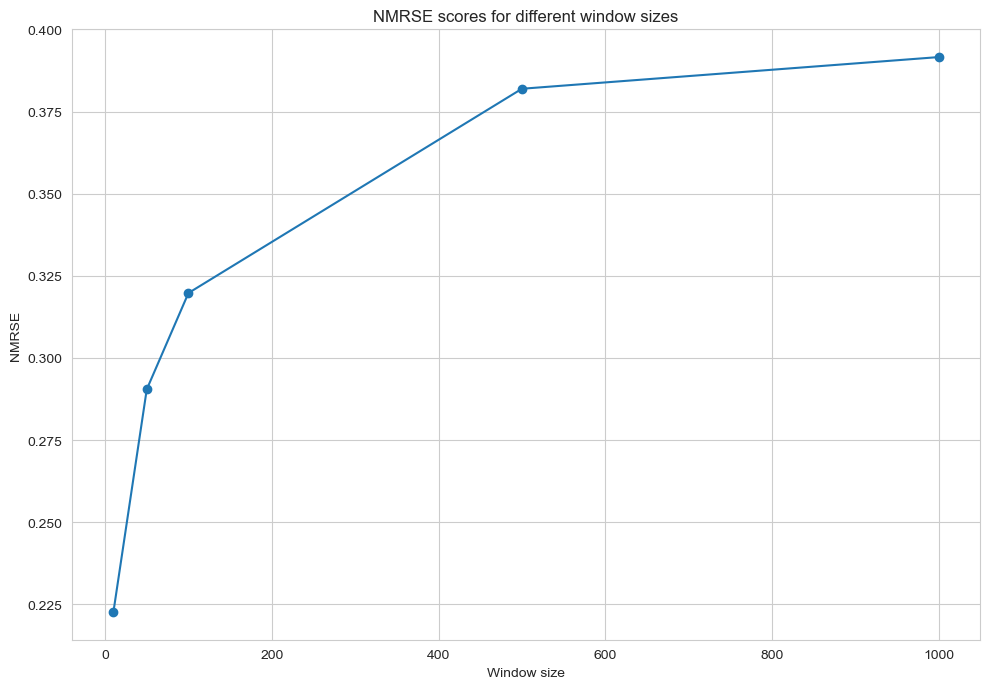

In [12]:
# Let's plot the results to see if there is a clear winner
sizes = [score['window_size'] for score in window_scores]
nmrse = [score['nmrse'] for score in window_scores]

plt.figure(figsize=(10, 7))
plt.plot(sizes, nmrse, marker='o')
plt.xlabel('Window size')
plt.ylabel('NMRSE')
plt.title('NMRSE scores for different window sizes')

plt.tight_layout()
plt.show()

In [13]:
# Get the best window size
best_window_optimal = window_scores[np.argmin(nmrse)]['window_size']

print(f"Best Window Size: {best_window_optimal}")

Best Window Size: 10


In [14]:
run_emas_optimal = False

In [15]:
# Now we will try the exponential_moving_average method

if run_emas_optimal:
    alphas = [0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

    ema_scores = []

    for alpha in alphas:
        x_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(alpha, X_train_scaled, y_train_encoded)
        x_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(alpha, X_val_scaled, y_val_encoded)
        x_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(alpha, X_test_scaled, y_test_encoded)

        input_weights = generate_input_weights(n_neurons, x_train_ema.shape[1], density, input_weight_type)

        basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights())

        basic_esn.fit(x_train_ema, y_train_ema, x_val=x_val_ema, y_val=y_val_ema)

        y_pred = basic_esn.forward(x_test_ema)

        # Before we can score the model, we need to decode the one-hot encoded labels
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_ema)

        # Calculate the NMRSE score
        nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_test_decoded.max() - y_test_decoded.min())

        ema_scores.append({'alpha': alpha, 'nmrse': nrmse})

else:
    ema_scores = [{'alpha': 0.001, 'nmrse': 0.25577295332624844}, {'alpha': 0.01, 'nmrse': 0.24683433791492262},
                  {'alpha': 0.1, 'nmrse': 0.24636975786767631}, {'alpha': 0.5, 'nmrse': 0.2514625787545563},
                  {'alpha': 0.7, 'nmrse': 0.2484534540576421}, {'alpha': 0.8, 'nmrse': 0.2480578010511014},
                  {'alpha': 0.9, 'nmrse': 0.2458151023205218}, {'alpha': 0.95, 'nmrse': 0.241183253665914},
                  {'alpha': 0.99, 'nmrse': 0.2481419529433462}, {'alpha': 0.999, 'nmrse': 0.23720339029842488}]

In [16]:
print(ema_scores)

[{'alpha': 0.001, 'nmrse': 0.25577295332624844}, {'alpha': 0.01, 'nmrse': 0.24683433791492262}, {'alpha': 0.1, 'nmrse': 0.24636975786767631}, {'alpha': 0.5, 'nmrse': 0.2514625787545563}, {'alpha': 0.7, 'nmrse': 0.2484534540576421}, {'alpha': 0.8, 'nmrse': 0.2480578010511014}, {'alpha': 0.9, 'nmrse': 0.2458151023205218}, {'alpha': 0.95, 'nmrse': 0.241183253665914}, {'alpha': 0.99, 'nmrse': 0.2481419529433462}, {'alpha': 0.999, 'nmrse': 0.23720339029842488}]


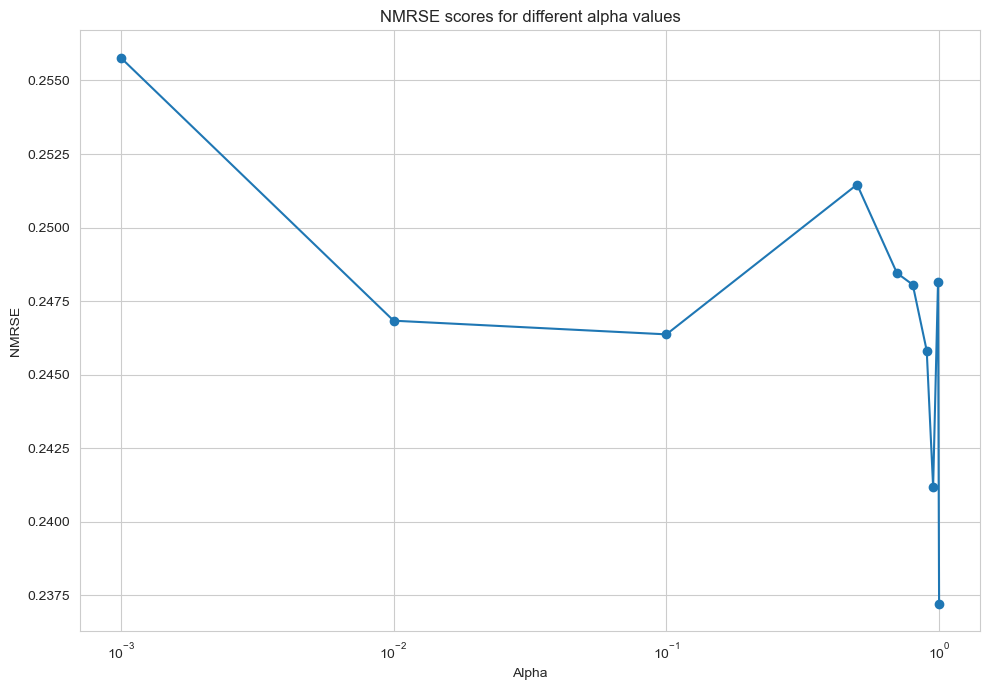

In [17]:
# Let's plot the results to see if there is a clear winner
alphas = [score['alpha'] for score in ema_scores]
nmrse = [score['nmrse'] for score in ema_scores]

plt.figure(figsize=(10, 7))

plt.plot(alphas, nmrse, marker='o')
plt.xlabel('Alpha')
plt.ylabel('NMRSE')
plt.title('NMRSE scores for different alpha values')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [18]:
# Get the best alpha
best_alpha_optimal = ema_scores[np.argmin(nmrse)]['alpha']

print(f"Best EMA Alpha: {best_alpha_optimal}")

Best EMA Alpha: 0.999


In [19]:
run_fourier_optimal = False

In [20]:
# Now we will try the fourier_smoothing method

if run_fourier_optimal:
    thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

    fourier_scores = []

    for threshold in thresholds:
        x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, threshold)
        x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, threshold)
        x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, threshold)

        input_weights = generate_input_weights(n_neurons, x_train_fourier.shape[1], density, input_weight_type)

        basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights())

        basic_esn.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)

        y_pred = basic_esn.forward(x_test_fourier)

        # Before we can score the model, we need to decode the one-hot encoded labels
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

        # Calculate the NMRSE score
        nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_test_decoded.max() - y_test_decoded.min())

        fourier_scores.append({'threshold': threshold, 'nmrse': nrmse})

else:
    fourier_scores = [{'threshold': 1000.0, 'nmrse': 0.2562997619214603},
                      {'threshold': 100.0, 'nmrse': 0.2576819098290108},
                      {'threshold': 10.0, 'nmrse': 0.2563173837643941},
                      {'threshold': 1.0, 'nmrse': 0.24849645201146137}, {'threshold': 0.1, 'nmrse': 0.2261314397229505},
                      {'threshold': 0.01, 'nmrse': 0.31659739514752616},
                      {'threshold': 0.001, 'nmrse': 0.3844482746039507},
                      {'threshold': 0.0001, 'nmrse': 0.4379391152907871},
                      {'threshold': 1e-05, 'nmrse': 0.4692323611136562}]

In [21]:
print(fourier_scores)

[{'threshold': 1000.0, 'nmrse': 0.2562997619214603}, {'threshold': 100.0, 'nmrse': 0.2576819098290108}, {'threshold': 10.0, 'nmrse': 0.2563173837643941}, {'threshold': 1.0, 'nmrse': 0.24849645201146137}, {'threshold': 0.1, 'nmrse': 0.2261314397229505}, {'threshold': 0.01, 'nmrse': 0.31659739514752616}, {'threshold': 0.001, 'nmrse': 0.3844482746039507}, {'threshold': 0.0001, 'nmrse': 0.4379391152907871}, {'threshold': 1e-05, 'nmrse': 0.4692323611136562}]


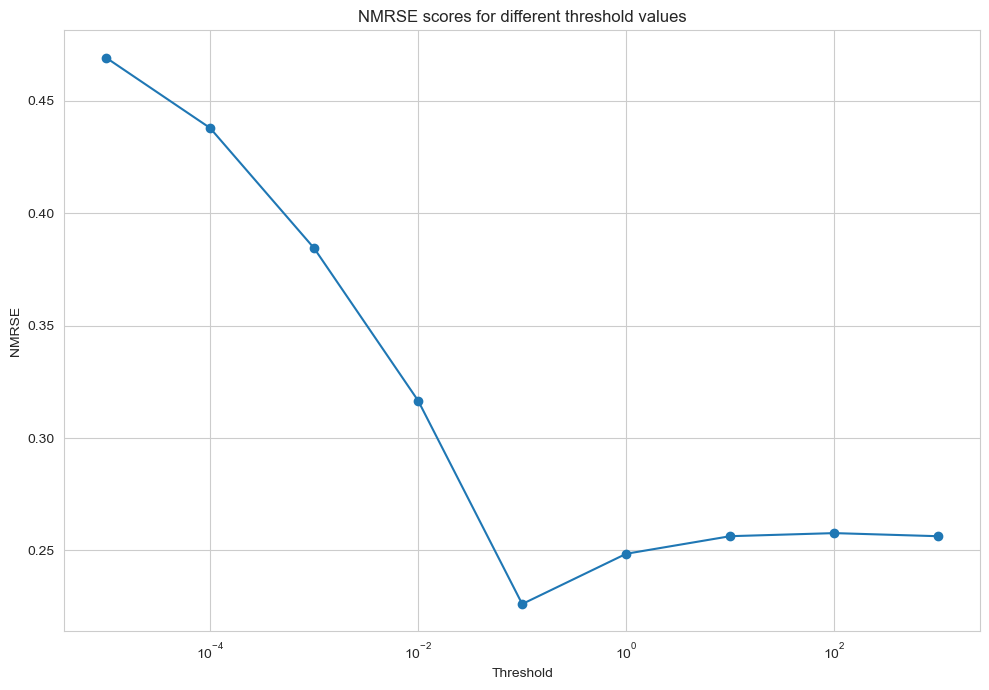

In [22]:
# Let's plot the results to see if there is a clear winner
thresholds = [score['threshold'] for score in fourier_scores]
nmrse = [score['nmrse'] for score in fourier_scores]

plt.figure(figsize=(10, 7))

plt.plot(thresholds, nmrse, marker='o')
plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.title('NMRSE scores for different threshold values')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [23]:
# Get the best threshold
best_threshold_optimal = fourier_scores[np.argmin(nmrse)]['threshold']

print(f"Best Fourier Threshold: {best_threshold_optimal}")

Best Fourier Threshold: 0.1


In [24]:
# As with the ridge baseline, let's try combining fourier smoothing with a windowing method
run_windows_fourier_optimal = False

In [25]:
if run_windows_fourier_optimal:
    window_sizes = [10, 50, 100, 500, 1000]
    thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

    pipeline_steps = ['buffered_windows', 'fourier_smoothing']

    window_fourier_scores = []

    for window_size in window_sizes:
        for threshold in thresholds:
            pipeline_params = [window_size, threshold]

            x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps,
                                                                                            X_train_scaled,
                                                                                            y_train_encoded,
                                                                                            pipeline_params)

            x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                                        y_val_encoded, pipeline_params)

            x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                                          y_test_encoded,
                                                                                          pipeline_params)

            input_weights = generate_input_weights(n_neurons, x_train_windowed_fourier.shape[1], density,
                                                   input_weight_type)

            basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius,
                                 gamma=gamma, sparsity=sparsity, W_in=input_weights,
                                 class_weights=data_preparation.get_class_weights())

            basic_esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                          y_val=y_val_windowed_fourier)

            y_pred = basic_esn.forward(x_test_windowed_fourier)

            # Before we can score the model, we need to decode the one-hot encoded labels
            # As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
            # And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
            y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[1] // window_size)
            y_test_reshaped = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[1] // window_size)

            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_reshaped)
            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_reshaped)

            # Calculate the NMRSE score
            nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_test_decoded.max() - y_test_decoded.min())

            window_fourier_scores.append({'window_size': window_size, 'threshold': threshold, 'nmrse': nrmse})

else:
    window_fourier_scores = [{'window_size': 10, 'threshold': 1000.0, 'nmrse': 0.2853287900540981},
                             {'window_size': 10, 'threshold': 100.0, 'nmrse': 0.2789865239780679},
                             {'window_size': 10, 'threshold': 10.0, 'nmrse': 0.29319770432849035},
                             {'window_size': 10, 'threshold': 1.0, 'nmrse': 0.2798729931720429},
                             {'window_size': 10, 'threshold': 0.1, 'nmrse': 0.3116976248146437},
                             {'window_size': 10, 'threshold': 0.01, 'nmrse': 0.35329488676319437},
                             {'window_size': 10, 'threshold': 0.001, 'nmrse': 0.44391926672708576},
                             {'window_size': 10, 'threshold': 0.0001, 'nmrse': 0.4597445078001562},
                             {'window_size': 10, 'threshold': 1e-05, 'nmrse': 0.3596832589206399},
                             {'window_size': 50, 'threshold': 1000.0, 'nmrse': 0.3172134610537775},
                             {'window_size': 50, 'threshold': 100.0, 'nmrse': 0.3139550646780654},
                             {'window_size': 50, 'threshold': 10.0, 'nmrse': 0.3169463647125123},
                             {'window_size': 50, 'threshold': 1.0, 'nmrse': 0.3198200969356743},
                             {'window_size': 50, 'threshold': 0.1, 'nmrse': 0.378828479272364},
                             {'window_size': 50, 'threshold': 0.01, 'nmrse': 0.4497008745041486},
                             {'window_size': 50, 'threshold': 0.001, 'nmrse': 0.4491369512192049},
                             {'window_size': 50, 'threshold': 0.0001, 'nmrse': 0.44486721005849045},
                             {'window_size': 50, 'threshold': 1e-05, 'nmrse': 0.5691745799385438},
                             {'window_size': 100, 'threshold': 1000.0, 'nmrse': 0.3358416283150872},
                             {'window_size': 100, 'threshold': 100.0, 'nmrse': 0.33749150052214116},
                             {'window_size': 100, 'threshold': 10.0, 'nmrse': 0.32489067608408106},
                             {'window_size': 100, 'threshold': 1.0, 'nmrse': 0.3158158007223917},
                             {'window_size': 100, 'threshold': 0.1, 'nmrse': 0.4421357002681729},
                             {'window_size': 100, 'threshold': 0.01, 'nmrse': 0.49805901688775667},
                             {'window_size': 100, 'threshold': 0.001, 'nmrse': 0.4437725724625122},
                             {'window_size': 100, 'threshold': 0.0001, 'nmrse': 0.4443966403438933},
                             {'window_size': 100, 'threshold': 1e-05, 'nmrse': 0.8098323992283787},
                             {'window_size': 500, 'threshold': 1000.0, 'nmrse': 0.4015791047339253},
                             {'window_size': 500, 'threshold': 100.0, 'nmrse': 0.3865209079670161},
                             {'window_size': 500, 'threshold': 10.0, 'nmrse': 0.3918577169923759},
                             {'window_size': 500, 'threshold': 1.0, 'nmrse': 0.3989483038655656},
                             {'window_size': 500, 'threshold': 0.1, 'nmrse': 0.4423761210461257},
                             {'window_size': 500, 'threshold': 0.01, 'nmrse': 0.4740366753378635},
                             {'window_size': 500, 'threshold': 0.001, 'nmrse': 0.4729651704813907},
                             {'window_size': 500, 'threshold': 0.0001, 'nmrse': 0.7406112478761454},
                             {'window_size': 500, 'threshold': 1e-05, 'nmrse': 0.5658577090535012},
                             {'window_size': 1000, 'threshold': 1000.0, 'nmrse': 0.39826776294998273},
                             {'window_size': 1000, 'threshold': 100.0, 'nmrse': 0.42351444281288203},
                             {'window_size': 1000, 'threshold': 10.0, 'nmrse': 0.41407212161409207},
                             {'window_size': 1000, 'threshold': 1.0, 'nmrse': 0.408560746396236},
                             {'window_size': 1000, 'threshold': 0.1, 'nmrse': 0.45899013816369266},
                             {'window_size': 1000, 'threshold': 0.01, 'nmrse': 0.5345250947187041},
                             {'window_size': 1000, 'threshold': 0.001, 'nmrse': 0.48929046036255924},
                             {'window_size': 1000, 'threshold': 0.0001, 'nmrse': 0.5158023395676504},
                             {'window_size': 1000, 'threshold': 1e-05, 'nmrse': 0.6832726607885331}]

In [26]:
print(window_fourier_scores)

[{'window_size': 10, 'threshold': 1000.0, 'nmrse': 0.2853287900540981}, {'window_size': 10, 'threshold': 100.0, 'nmrse': 0.2789865239780679}, {'window_size': 10, 'threshold': 10.0, 'nmrse': 0.29319770432849035}, {'window_size': 10, 'threshold': 1.0, 'nmrse': 0.2798729931720429}, {'window_size': 10, 'threshold': 0.1, 'nmrse': 0.3116976248146437}, {'window_size': 10, 'threshold': 0.01, 'nmrse': 0.35329488676319437}, {'window_size': 10, 'threshold': 0.001, 'nmrse': 0.44391926672708576}, {'window_size': 10, 'threshold': 0.0001, 'nmrse': 0.4597445078001562}, {'window_size': 10, 'threshold': 1e-05, 'nmrse': 0.3596832589206399}, {'window_size': 50, 'threshold': 1000.0, 'nmrse': 0.3172134610537775}, {'window_size': 50, 'threshold': 100.0, 'nmrse': 0.3139550646780654}, {'window_size': 50, 'threshold': 10.0, 'nmrse': 0.3169463647125123}, {'window_size': 50, 'threshold': 1.0, 'nmrse': 0.3198200969356743}, {'window_size': 50, 'threshold': 0.1, 'nmrse': 0.378828479272364}, {'window_size': 50, 'thre

In [27]:
# Get the best window size and threshold
best_window_fourier_optimal = window_fourier_scores[np.argmin([score['nmrse'] for score in window_fourier_scores])]
best_window_size_optimal = best_window_fourier_optimal['window_size']
best_threshold_fourier_optimal = best_window_fourier_optimal['threshold']

print(f"Best Window Size: {best_window_size_optimal}")
print(f"Best Fourier Threshold: {best_threshold_fourier_optimal}")

Best Window Size: 10
Best Fourier Threshold: 100.0


In [28]:
# Now that we have tried each preprocessing method separately, let's train each of the best models and compare the results

best_window_pickle = "basicESN_har70_window_optimal.pkl"

# First, we will train the model with the best window size
x_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(best_window_optimal, X_train_scaled,
                                                                        y_train_encoded)
x_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(best_window_optimal, X_val_scaled, y_val_encoded)
x_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(best_window_optimal, X_test_scaled,
                                                                      y_test_encoded)

input_weights = generate_input_weights(n_neurons, x_train_windowed.shape[1], density, input_weight_type, seed=42)

if run_windows_optimal or not os.path.exists(best_window_pickle):
    basic_esn_window = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                                sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights(),
                                seed=42)
    
    basic_esn_window.fit(x_train_windowed, y_train_windowed, x_val=x_val_windowed, y_val=y_val_windowed)
    
    with open(best_window_pickle, 'wb') as f:
        pickle.dump(basic_esn_window, f)
        
else:
    with open(best_window_pickle, 'rb') as f:
        basic_esn_window = pickle.load(f)

y_pred_window = basic_esn_window.forward(x_test_windowed)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
# And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
y_pred_reshaped_window = y_pred_window.reshape(-1, y_pred_window.shape[1] // best_window_optimal)
y_test_reshaped_window = y_test_windowed.reshape(-1, y_test_windowed.shape[1] // best_window_optimal)

y_pred_decoded_window = data_preparation.get_encoder().inverse_transform(y_pred_reshaped_window)
y_test_decoded_window = data_preparation.get_encoder().inverse_transform(y_test_reshaped_window)

# Calculate the NMRSE score
nrmse_window = np.sqrt(mean_squared_error(y_test_decoded_window, y_pred_decoded_window)) / (
        y_test_decoded_window.max() - y_test_decoded_window.min())

print(f"NMRSE for best window size: {nrmse_window}")

Buffered data shape: (135765, 60), (135765, 70)
Buffered data shape: (33941, 60), (33941, 70)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 135765/135765 [00:39<00:00, 3479.98it/s]


Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 33941/33941 [00:09<00:00, 3510.78it/s]


Shape of previous_states: (33941, 500)


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.31853e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 1e-05, Score: 0.2568968257446377


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.31954e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 5.994842503189409e-05, Score: 0.2568422975755419


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.32875e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.00035938136638046257, Score: 0.25691673827463496


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.3812e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0021544346900318843, Score: 0.2569610163504465


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.69699e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.25753180692142685


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.16579e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.2601857935121918


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.69546e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.2700926397660291
Alpha: 2.782559402207126, Score: 0.2890453537092586
Alpha: 16.68100537200059, Score: 0.29932034704344973
Alpha: 100.0, Score: 0.28802981961782825
Best alpha: 16.68100537200059
Readout layer fitted.


100%|██████████| 56255/56255 [00:15<00:00, 3529.33it/s]

Shape of previous_states: (56255, 500)
NMRSE for best window size: 0.23161274827432818


In [29]:
# Next, we will train the model with the best EMA alpha

best_ema_pickle = "basicESN_har70_ema_optimal.pkl"

x_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(best_alpha_optimal, X_train_scaled,
                                                                        y_train_encoded)
x_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(best_alpha_optimal, X_val_scaled, y_val_encoded)
x_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(best_alpha_optimal, X_test_scaled, y_test_encoded)

input_weights = generate_input_weights(n_neurons, x_train_ema.shape[1], density, input_weight_type, seed=42)

if run_emas_optimal or not os.path.exists(best_ema_pickle):
    basic_esn_ema = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights(),
                             seed=42)
    
    basic_esn_ema.fit(x_train_ema, y_train_ema, x_val=x_val_ema, y_val=y_val_ema)
    
    with open(best_ema_pickle, 'wb') as f:
        pickle.dump(basic_esn_ema, f)
        
else:
    with open(best_ema_pickle, 'rb') as f:
        basic_esn_ema = pickle.load(f)

y_pred_ema = basic_esn_ema.forward(x_test_ema)

# Before we can score the model, we need to decode the one-hot encoded labels
y_pred_decoded_ema = data_preparation.get_encoder().inverse_transform(y_pred_ema)
y_test_decoded_ema = data_preparation.get_encoder().inverse_transform(y_test_ema)

# Calculate the NMRSE score
nrmse_ema = np.sqrt(mean_squared_error(y_test_decoded_ema, y_pred_decoded_ema)) / (
        y_test_decoded_ema.max() - y_test_decoded_ema.min())

print(f"NMRSE for best EMA alpha: {nrmse_ema}")

Smoothed data shape: (1357646, 6), (1357646, 7)
Smoothed data shape: (339404, 6), (339404, 7)
Smoothed data shape: (562547, 6), (562547, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 1357646/1357646 [06:19<00:00, 3580.95it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 339404/339404 [01:34<00:00, 3601.76it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.3052178447452271
Alpha: 5.994842503189409e-05, Score: 0.3052220522943176
Alpha: 0.00035938136638046257, Score: 0.30525285955185044
Alpha: 0.0021544346900318843, Score: 0.3054350076292555
Alpha: 0.01291549665014884, Score: 0.3063795071479735
Alpha: 0.0774263682681127, Score: 0.30938930809510856
Alpha: 0.4641588833612782, Score: 0.31135501245162983


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.75969e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.3048552928936276


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.46824e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 16.68100537200059, Score: 0.2905893788353902
Alpha: 100.0, Score: 0.25732162689108956
Best alpha: 0.4641588833612782
Readout layer fitted.


100%|██████████| 562547/562547 [02:38<00:00, 3549.98it/s]


Shape of previous_states: (562547, 500)
NMRSE for best EMA alpha: 0.240898797111617


In [30]:
# Next, we will train the model with the best Fourier threshold

best_fourier_pickle = "basicESN_har70_fourier_optimal.pkl"

x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold_optimal)
x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold_optimal)
x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold_optimal)

input_weights = generate_input_weights(n_neurons, x_train_fourier.shape[1], density, input_weight_type, seed=42)

if run_fourier_optimal or not os.path.exists(best_fourier_pickle):
    basic_esn_fourier = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                                 sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights(),
                                 seed=42)
    
    basic_esn_fourier.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)
    
    with open(best_fourier_pickle, 'wb') as f:
        pickle.dump(basic_esn_fourier, f)
        
else:
    with open(best_fourier_pickle, 'rb') as f:
        basic_esn_fourier = pickle.load(f)

y_pred_fourier = basic_esn_fourier.forward(x_test_fourier)

# Before we can score the model, we need to decode the one-hot encoded labels
y_pred_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_pred_fourier)
y_test_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse_fourier = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
        y_test_decoded_fourier.max() - y_test_decoded_fourier.min())

print(f"NMRSE for best Fourier threshold: {nrmse_fourier}")

Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 1357646/1357646 [06:45<00:00, 3347.13it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 339404/339404 [01:45<00:00, 3229.70it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.32419656332162206
Alpha: 5.994842503189409e-05, Score: 0.3241999081570528
Alpha: 0.00035938136638046257, Score: 0.3242163080806892
Alpha: 0.0021544346900318843, Score: 0.324294945484849
Alpha: 0.01291549665014884, Score: 0.3245844676129967
Alpha: 0.0774263682681127, Score: 0.3241495359133758
Alpha: 0.4641588833612782, Score: 0.3186057918048824


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.76855e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.305225620874503


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.45617e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 16.68100537200059, Score: 0.28084025845684296
Alpha: 100.0, Score: 0.241029467754825
Best alpha: 0.01291549665014884
Readout layer fitted.


100%|██████████| 562547/562547 [02:46<00:00, 3381.48it/s]


Shape of previous_states: (562547, 500)
NMRSE for best Fourier threshold: 0.2324669274111717


In [31]:
# Finally, we will train the model with the best window size and Fourier threshold

best_window_fourier_pickle = "basicESN_har70_window_fourier_optimal.pkl"

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_train_scaled,
                                                                                y_train_encoded,
                                                                                [best_threshold_fourier_optimal,
                                                                                 best_window_size_optimal])
x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled, y_val_encoded,
                                                                            [best_threshold_fourier_optimal,
                                                                                best_window_size_optimal])
x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                              y_test_encoded, [best_threshold_fourier_optimal,
                                                                                best_window_size_optimal])

input_weights = generate_input_weights(n_neurons, x_train_windowed_fourier.shape[1], density, input_weight_type,
                                       seed=42)

if run_windows_fourier_optimal or not os.path.exists(best_window_fourier_pickle):
    basic_esn_window_fourier = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius,
                                        gamma=gamma, sparsity=sparsity, W_in=input_weights,
                                        class_weights=data_preparation.get_class_weights(), seed=42)
    
    basic_esn_window_fourier.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                                 y_val=y_val_windowed_fourier)
    
    with open(best_window_fourier_pickle, 'wb') as f:
        pickle.dump(basic_esn_window_fourier, f)
        
else:
    with open(best_window_fourier_pickle, 'rb') as f:
        basic_esn_window_fourier = pickle.load(f)

y_pred_window_fourier = basic_esn_window_fourier.forward(x_test_windowed_fourier)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
# And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
y_pred_reshaped_window_fourier = y_pred_window_fourier.reshape(-1, y_pred_window_fourier.shape[
    1] // best_window_size_optimal)
y_test_reshaped_window_fourier = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[
    1] // best_window_size_optimal)

y_pred_decoded_window_fourier = data_preparation.get_encoder().inverse_transform(y_pred_reshaped_window_fourier)
y_test_decoded_window_fourier = data_preparation.get_encoder().inverse_transform(y_test_reshaped_window_fourier)

# Calculate the NMRSE score
nrmse_window_fourier = np.sqrt(mean_squared_error(y_test_decoded_window_fourier, y_pred_decoded_window_fourier)) / (
        y_test_decoded_window_fourier.max() - y_test_decoded_window_fourier.min())

print(f"NMRSE for best window size and Fourier threshold: {nrmse_window_fourier}")

Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 135765/135765 [00:36<00:00, 3698.91it/s]


Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 33941/33941 [00:09<00:00, 3641.45it/s]


Shape of previous_states: (33941, 500)


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.31853e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 1e-05, Score: 0.2568968257446377


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.31954e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 5.994842503189409e-05, Score: 0.2568422975755419


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.32875e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.00035938136638046257, Score: 0.25691673827463496


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.3812e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0021544346900318843, Score: 0.2569610163504465


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.69699e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.25753180692142685


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.16579e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.2601857935121918


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.69546e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.2700926397660291
Alpha: 2.782559402207126, Score: 0.2890453537092586
Alpha: 16.68100537200059, Score: 0.29932034704344973
Alpha: 100.0, Score: 0.28802981961782825
Best alpha: 16.68100537200059
Readout layer fitted.


100%|██████████| 56255/56255 [00:15<00:00, 3534.69it/s]

Shape of previous_states: (56255, 500)
NMRSE for best window size and Fourier threshold: 0.23051843847817363


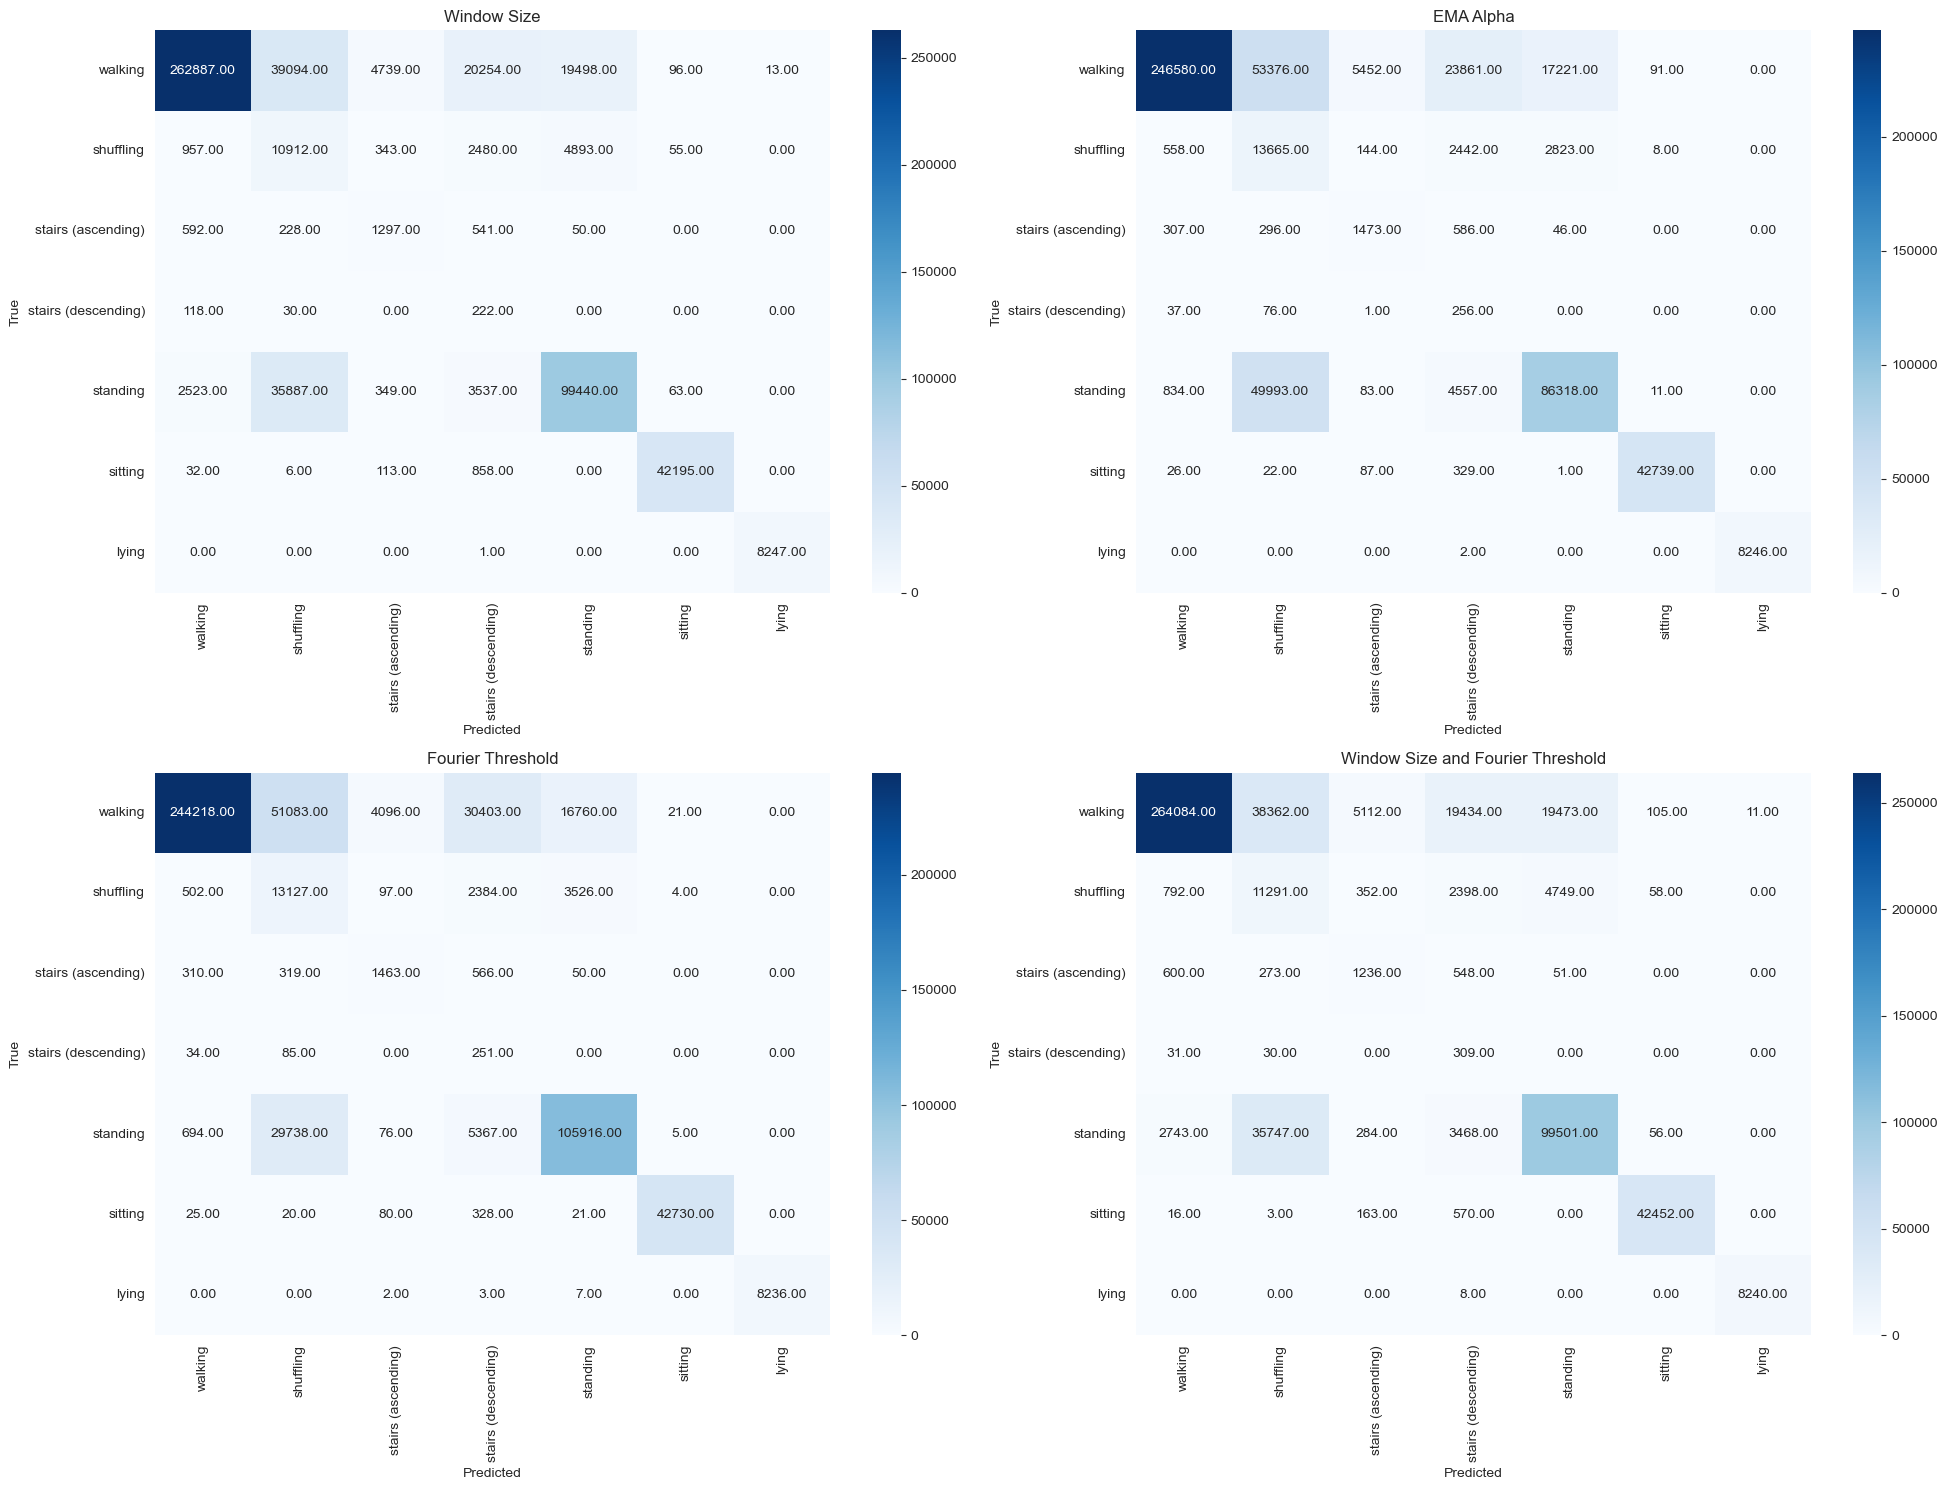

In [32]:
# Let's plot the confusion matrices for each model to see if there are any differences in the classification performance
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.title('Window Size')
sns.heatmap(confusion_matrix(y_test_decoded_window, y_pred_decoded_window), annot=True, fmt='.2f', xticklabels=labels,
            yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 2)
plt.title('EMA Alpha')
sns.heatmap(confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema), annot=True, fmt='.2f', xticklabels=labels,
            yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 3)
plt.title('Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier), annot=True, fmt='.2f', xticklabels=labels,
            yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 4)
plt.title('Window Size and Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_window_fourier, y_pred_decoded_window_fourier), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

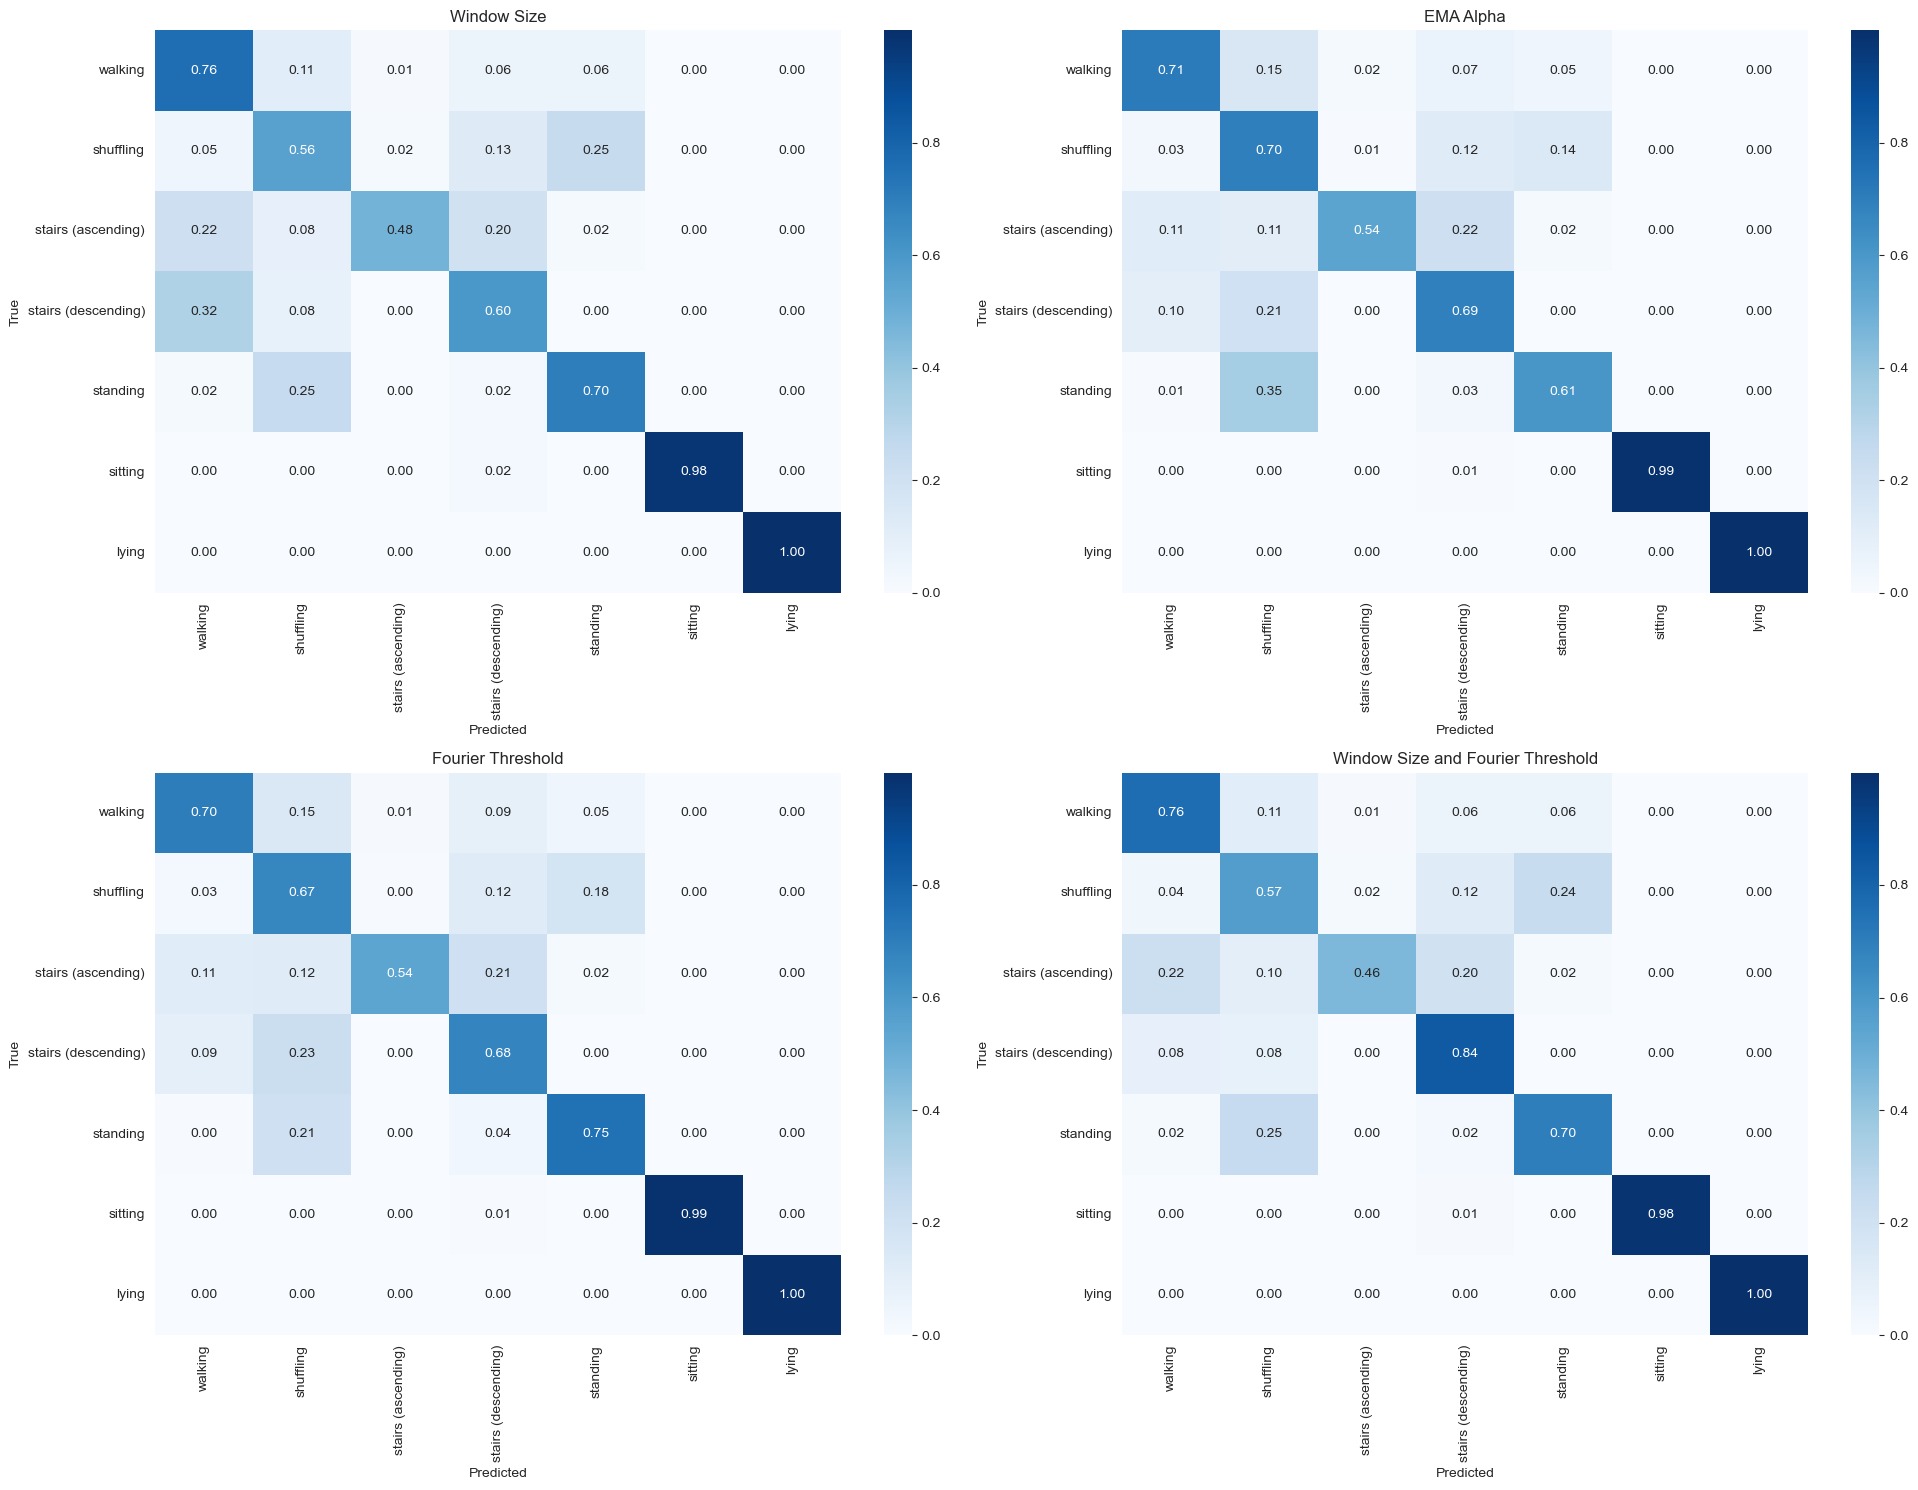

In [33]:
# Let's do the same but with a normalised confusion matrix as there is a large class imbalance
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.title('Window Size')
sns.heatmap(confusion_matrix(y_test_decoded_window, y_pred_decoded_window, normalize='true'), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 2)
plt.title('EMA Alpha')
sns.heatmap(confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema, normalize='true'), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 3)
plt.title('Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier, normalize='true'), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 4)
plt.title('Window Size and Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_window_fourier, y_pred_decoded_window_fourier, normalize='true'),
            annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [34]:
# Let's also print the classification report for each model
from sklearn.metrics import classification_report

print("Window Size")
print(classification_report(y_test_decoded_window, y_pred_decoded_window))
print("-" * 80)

print("EMA Alpha")
print(classification_report(y_test_decoded_ema, y_pred_decoded_ema))
print("-" * 80)

print("Fourier Threshold")
print(classification_report(y_test_decoded_fourier, y_pred_decoded_fourier))
print("-" * 80)

print("Window Size and Fourier Threshold")
print(classification_report(y_test_decoded_window_fourier, y_pred_decoded_window_fourier))

Window Size
              precision    recall  f1-score   support

           1       0.98      0.76      0.86    346581
           3       0.13      0.56      0.21     19640
           4       0.19      0.48      0.27      2708
           5       0.01      0.60      0.02       370
           6       0.80      0.70      0.75    141799
           7       0.99      0.98      0.99     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.76    562550
   macro avg       0.59      0.72      0.58    562550
weighted avg       0.91      0.76      0.82    562550

--------------------------------------------------------------------------------
EMA Alpha
              precision    recall  f1-score   support

           1       0.99      0.71      0.83    346581
           3       0.12      0.70      0.20     19640
           4       0.20      0.54      0.30      2708
           5       0.01      0.69      0.02       370
           6       0.81      

In [35]:
# From our basicESN testing, we know that there are some ranges of suboptimal hyperparameters, so these can be excluded from the search space to save time

# This is constant as this performed the best, whilst still computing in a reasonable time
n_neurons = 500

density_range = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]
leakage_range = [0.6, 0.75, 0.8, 0.9, 0.95, 0.99]
spectral_radius_range = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
gamma_range = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
sparsity_range = [0.1, 0.3, 0.5, 0.7, 0.9]

input_weight_type = 'uniform'

# When working on the ridge baseline, 
window_sizes = [10, 50, 100]
alphas = [0.01, 0.1, 0.5, 0.9, 0.99]
thresholds = [1e-1, 1e-2, 1e-3, 1e-4]

In [36]:
# The fourier smoothing seems to be performing the best at present, so let's try some hyperparameter tuning with this method as a preprocessing step
run_fourier_hyperparameter_tuning = False

In [37]:

# Due to the size of the search space, we try using hyperopt to find the best hyperparameters

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


def fourier_objective(params):
    input_weights = generate_input_weights(n_neurons, X_train_scaled.shape[1], params['density'], input_weight_type,
                                           seed=42)

    basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=params['leakage'], spectral_radius=params['spectral_radius'],
                         gamma=params['gamma'], sparsity=params['sparsity'], W_in=input_weights,
                         class_weights=data_preparation.get_class_weights(), seed=42, is_optimising=True)

    x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, params['threshold'])
    x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, params['threshold'])
    x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, params['threshold'])

    basic_esn.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)

    y_pred = basic_esn.forward(x_test_fourier)

    # Before we can score the model, we need to decode the one-hot encoded labels
    y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
    y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

    # Calculate the NMRSE score
    nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())

    return {'loss': nrmse, 'status': STATUS_OK}

In [38]:
n_iterations = 10

if run_fourier_hyperparameter_tuning:
    space = {
        'density': hp.choice('density', density_range),
        'leakage': hp.choice('leakage', leakage_range),
        'spectral_radius': hp.choice('spectral_radius', spectral_radius_range),
        'gamma': hp.choice('gamma', gamma_range),
        'sparsity': hp.choice('sparsity', sparsity_range),
        'threshold': hp.choice('threshold', thresholds)
    }

    trials = Trials()

    best = fmin(fourier_objective, space, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

    print(best)

else:
    best = {'density': 3, 'gamma': 4, 'leakage': 2, 'sparsity': 3, 'spectral_radius': 5, 'threshold': 0}

In [39]:
# Get the best hyperparameters
best_density_fourier = density_range[best['density']]
best_leakage_fourier = leakage_range[best['leakage']]
best_spectral_radius_fourier = spectral_radius_range[best['spectral_radius']]
best_gamma_fourier = gamma_range[best['gamma']]
best_sparsity_fourier = sparsity_range[best['sparsity']]
best_threshold_fourier = thresholds[best['threshold']]

print(f"Best Density: {best_density_fourier}")
print(f"Best Leakage: {best_leakage_fourier}")
print(f"Best Spectral Radius: {best_spectral_radius_fourier}")
print(f"Best Gamma: {best_gamma_fourier}")
print(f"Best Sparsity: {best_sparsity_fourier}")
print(f"Best Threshold: {best_threshold_fourier}")

Best Density: 0.9
Best Leakage: 0.8
Best Spectral Radius: 0.99
Best Gamma: 0.95
Best Sparsity: 0.7
Best Threshold: 0.1


In [40]:
# Now we will train the model with the best hyperparameters

basic_esn_augments_pickle = "basicESN_har70_augments.pkl"

input_weights = generate_input_weights(n_neurons, X_train_scaled.shape[1], best_density_fourier, input_weight_type, seed=42)

x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold_fourier)
x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold_fourier)
x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold_fourier)

if run_fourier_hyperparameter_tuning or not os.path.exists(basic_esn_augments_pickle):
    basic_esn_fourier = BasicESN(n_neurons=n_neurons, leakage_rate=best_leakage_fourier,
                                 spectral_radius=best_spectral_radius_fourier, gamma=best_gamma_fourier,
                                 sparsity=best_sparsity_fourier, W_in=input_weights,
                                 class_weights=data_preparation.get_class_weights(), seed=42)
    
    basic_esn_fourier.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)
    
    with open(basic_esn_augments_pickle, 'wb') as f:
        pickle.dump(basic_esn_fourier, f)
        
else:
    with open(basic_esn_augments_pickle, 'rb') as f:
        basic_esn_fourier = pickle.load(f)
        
y_pred_fourier = basic_esn_fourier.forward(x_test_fourier)

# Before we can score the model, we need to decode the one-hot encoded labels
y_pred_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_pred_fourier)
y_test_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse_fourier = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
        y_test_decoded_fourier.max() - y_test_decoded_fourier.min())

print(f"NMRSE for best hyperparameters: {nrmse_fourier}")

Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)


100%|██████████| 562547/562547 [02:44<00:00, 3412.61it/s]


Shape of previous_states: (562547, 500)
NMRSE for best hyperparameters: 0.35960049353256496


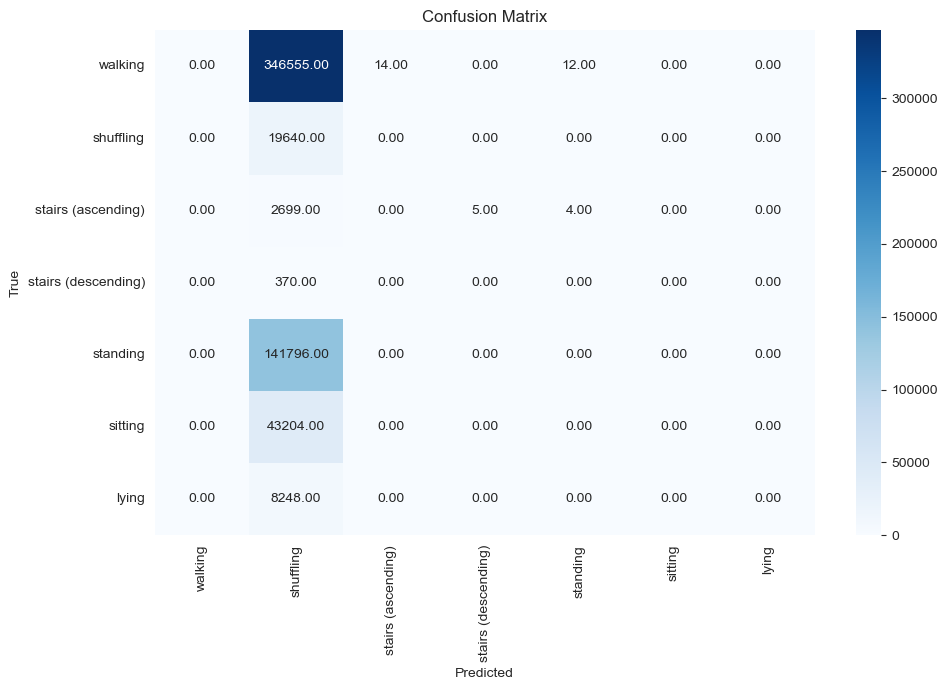

In [41]:
# Let's plot the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

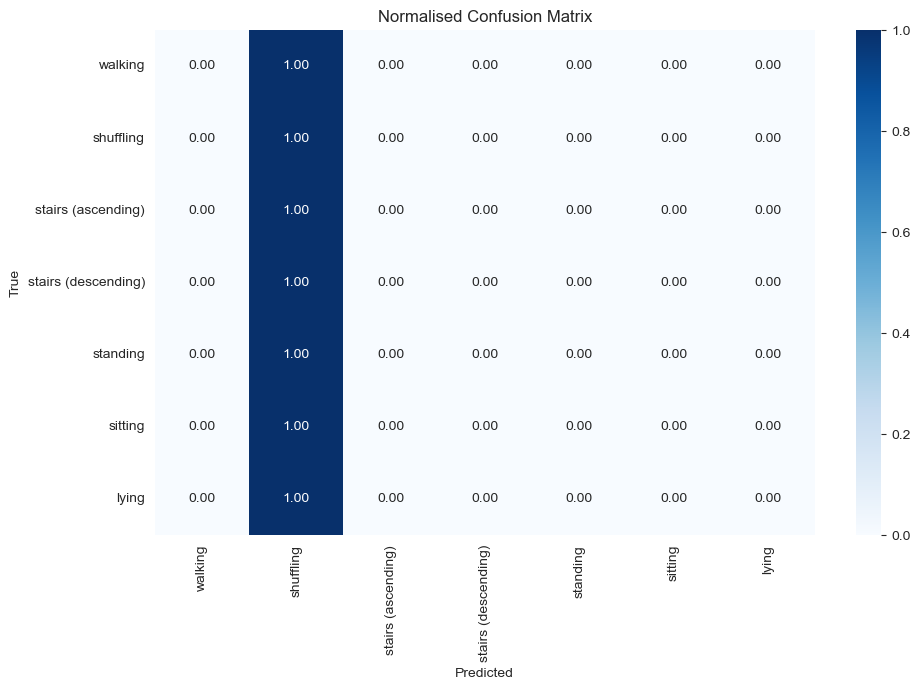

In [42]:
# Let's also print the normalised confusion matrix due to the class imbalance
norm_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')

plt.tight_layout()
plt.show()

In [43]:
# Finally, let's print the classification report for the best model
print(classification_report(y_test_decoded_fourier, y_pred_decoded_fourier))

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.03      1.00      0.07     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.00      0.00      0.00     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.03    562547
   macro avg       0.00      0.14      0.01    562547
weighted avg       0.00      0.03      0.00    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
